<a href="https://colab.research.google.com/github/neera-mital/KaggleNLPDisasterTweetsClassification/blob/main/kaggle_nlp_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset

#https://github.com/huggingface/transformers/issues/8879 for issue details on using Version 3
!pip install transformers==3
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [2]:
!pip install -q kaggle
from google.colab import files
#files.upload()

#!mkdir ~/.kaggle
#!cp -n kaggle.json ~/.kaggle/

###Make directory named kaggle and copy kaggle.json file there.
!chmod 600 ~/.kaggle/kaggle.json

###Change the permissions of the file.
###! kaggle datasets list
!kaggle competitions download -c nlp-getting-started
!ls

###import os
###for dirname, _, filenames in os.walk('./kaggle/'):
###    for filename in filenames:
###        print(os.path.join(dirname, filename))


sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
'kaggle (1).json'   sample_data		    test.csv
 kaggle.json	    sample_submission.csv   train.csv


In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.loc[df_train.keyword != ""].sample(5)



,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
         id                                               text  target
7603  10862  Officials say a quarantine is in place at an A...       1
7604  10863  #WorldNews Fallen powerlines on G:link tram: U...       1
7605  10864  on the flip side I'm at Walmart and there is a...       1
7606  10866  Suicide bomber kills 15 in Saudi security site...       1
7607  10867  #stormchase Violent Record Breaking EF-5 El Re...       1
7608  10869  Two giant cranes holding a bridge collapse int...       1
7609  10870  @aria_ahrary @TheTawniest The out of control w...       1
7610  10

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


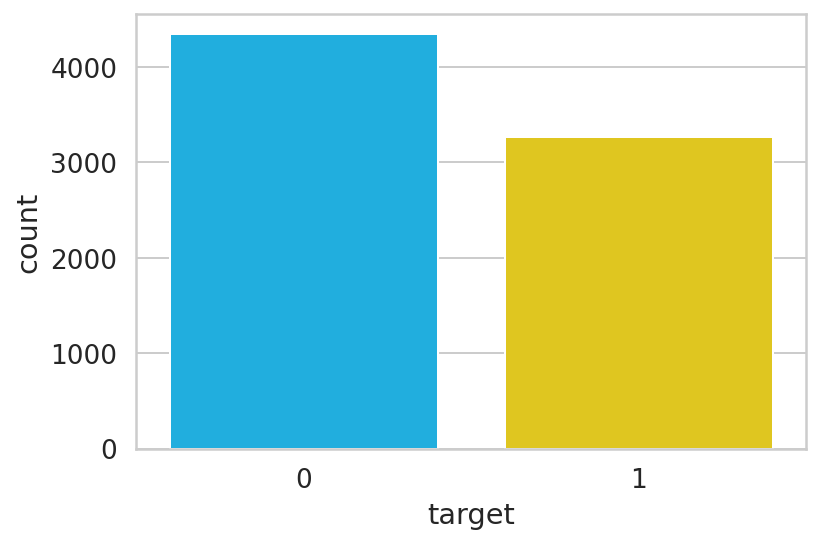

In [4]:
df_train.info()

df=df_train.drop(columns=['keyword', 'location'])
print(df.tail(10))
print(df.shape)

sns.countplot(df.target)

In [5]:
!python --version
print(f" Torch Version - {torch.__version__}")
#print(f" Transformers Version - { Transformers.__version__}")
device

Python 3.6.9
 Torch Version - 1.7.0+cu101


device(type='cuda', index=0)

In [6]:
###from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
#PRE_TRAINED_MODEL_NAME = 'bert-large-cased'
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

text_ip1 = "Cat ate the mouse."
text_ip2 = "[CLS] I will buy mouse and keyboard for the computer.[SEP]"

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(text_ip1))

# Print the sentence mapped to token ids.
print('Token IDs: 1 ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_ip1)))
print('Token IDs: 2 ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_ip2)))


Tokenized:  ['Cat', 'ate', 'the', 'mouse', '.']
Token IDs: 1  [8572, 8756, 1103, 10322, 119]
Token IDs: 2  [101, 146, 1209, 4417, 10322, 1105, 9303, 1111, 1103, 2775, 119, 102]


In [7]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.target.values
#print(sentences)
#print(labels)

max_len = 0
# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  106


In [8]:
#for label in labels:
#  print(label)

In [8]:
MAX_LEN = 120 #Max sentence length 

class GPReviewDataset(Dataset):
  def __init__(self, text, target, tokenizer, max_len):
    self.text = text
    self.target = target
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.target[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'target': torch.tensor(target, dtype=torch.long)
    }



In [9]:
df_train, df_val = train_test_split(
  df,
  test_size=0.2,
  random_state=RANDOM_SEED
)


'''df_test = train_test_split(
  df_test,
  test_size=1.0,
  random_state=RANDOM_SEED
)'''

df_train.shape, df_val.shape, df_test.shape
#test_df.shape

((6090, 3), (1523, 3), (3263, 4))

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    text=df.text.to_numpy(),
    target=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16


train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [11]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)


dict_keys(['text', 'input_ids', 'attention_mask', 'target'])
torch.Size([16, 120])
torch.Size([16, 120])
torch.Size([16])


In [12]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

#CLASSES
CLASS_LEN=2
model = SentimentClassifier(CLASS_LEN)
model = model.to(device)

In [13]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

#print(input_ids)

print(tokenizer.convert_ids_to_tokens(data['input_ids'][0]))
F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 120])
torch.Size([16, 120])
['[CLS]', 'Courage', '##ous', 'and', 'honest', 'analysis', 'of', 'need', 'to', 'use', 'Atomic', 'Bomb', 'in', '1945', '.', '#', 'Hiroshima', '##70', 'Japanese', 'military', 'refused', 'surrender', '.', 'https', ':', '/', '/', 't', '.', 'co', '/', 'V', '##hm', '##ty', '##T', '##pt', '##GR', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

tensor([[0.4301, 0.5699],
        [0.7942, 0.2058],
        [0.6668, 0.3332],
        [0.8540, 0.1460],
        [0.6259, 0.3741],
        [0.4160, 0.5840],
        [0.6768, 0.3232],
        [0.6763, 0.3237],
        [0.7364, 0.2636],
        [0.8152, 0.1848],
        [0.4247, 0.5753],
        [0.6669, 0.3331],
        [0.7584, 0.2416],
        [0.6080, 0.3920],
        [0.7038, 0.2962],
        [0.8378, 0.1622]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [14]:
EPOCHS = 8
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    target = d["target"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, target)
    correct_predictions += torch.sum(preds == target)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      target = d["target"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, target)
      correct_predictions += torch.sum(preds == target)
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
%%time

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.4906309457041147 accuracy 0.7842364532019704
Val   loss 0.43758562207221985 accuracy 0.8279711096520026

Epoch 2/8
----------
Train loss 0.31750096246756593 accuracy 0.8770114942528736
Val   loss 0.4884044696809724 accuracy 0.8332239001969796

Epoch 3/8
----------
Train loss 0.20576024560252903 accuracy 0.9328407224958949
Val   loss 0.7327211721567437 accuracy 0.7984241628365069

Epoch 4/8
----------
Train loss 0.13815767932078235 accuracy 0.9591133004926109
Val   loss 0.8872670864996811 accuracy 0.804333552199606

Epoch 5/8
----------
Train loss 0.10118249369378195 accuracy 0.9725779967159278
Val   loss 1.0028569648081127 accuracy 0.7997373604727511

Epoch 6/8
----------
Train loss 0.08114184251779585 accuracy 0.9773399014778326
Val   loss 1.0881430188310333 accuracy 0.794484569927774

Epoch 7/8
----------
Train loss 0.06287888578831168 accuracy 0.9804597701149426
Val   loss 1.1195406328188255 accuracy 0.8030203545633617

Epoch 8/8
----------
Train lo

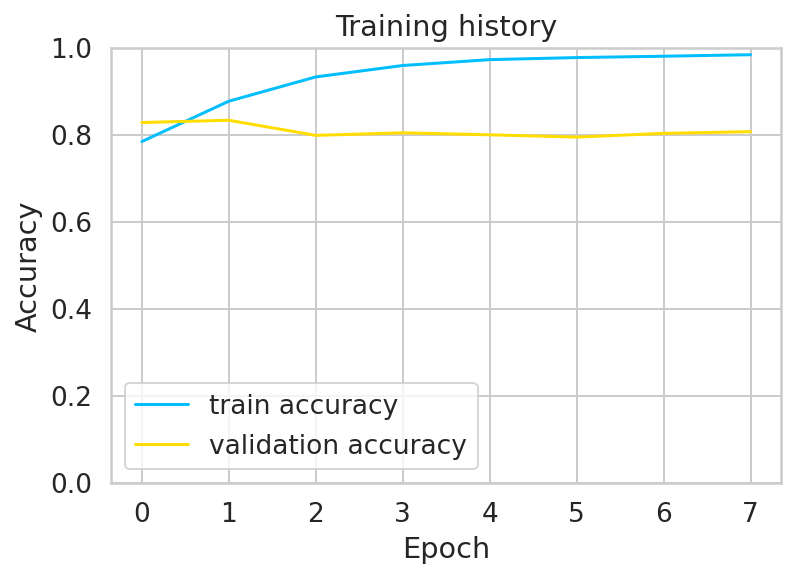

In [18]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [20]:
row_ids = []
row_texts = []
row_predictions = []

for i, row in df_test.iterrows():
    #print( f" {i} {row['id']}  {row['text']}" )
    encoding_comment = tokenizer.encode_plus(
      row['text'],
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt')
     
    input_ids = encoding_comment['input_ids'].to(device)
    attention_mask = encoding_comment['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    
    row_ids.append(row['id'])
    row_texts.append(row['text'])
    row_predictions.append(prediction.data.tolist()[0])

    #print(f"Input text: {row['text']}")
    #print(f'Sentiment  : {prediction}')



In [21]:
#row_texts
print(len(row_texts))
print(len(row_predictions))

'''
for i,t,p in zip(row_ids,row_texts,row_predictions):
  print(f' {i} {t} -> {p}')

'''

d = {'id': row_ids, 'target': row_predictions}
df_ans = pd.DataFrame(data=d)
df_ans.to_csv('submisson_nm1_v2.csv',index=False)
files.download('submisson_nm1_v2.csv')



3263
3263


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>